## 6. Stellar Mass Analysis

Advanced Exam: Section 6.

In this notebook, we have the following plots:


<ul>
    <li> Stellar Mass Validation </li>
    <li> Can we recovery $\mu_{\star}$? </li>
</ul>

###  Dataset

We use the otuput from the algoritgm BMA Stellar Mass (Palmese et al. 2019)

In [3]:
import numpy as np
from astropy.table import Table, vstack
from astropy.io.fits import getdata
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

# 'font.sans-serif': ['Arial',
#   'DejaVu Sans',
#   'Liberation Sans',
#   'Bitstream Vera Sans',
#   'sans-serif'],

In [4]:
root  = '/data/des61.a/data/johnny/COSMOS/BMA/'
infile= root+'bma_test_large.fits'
gal  = Table(getdata(infile))

In [5]:
## load cosmos data
cosmos_infile = '/data/des61.a/data/johnny/COSMOS/COSMOS2015_Laigle+_v1.1.fits'
cosmos0  = Table(getdata(cosmos_infile))

## load des deep field
des_deep_field_infile = '/data/des70.a/data/annis/StellarMass-2021/y3_deep_fields.fits'
des0 = Table(getdata(des_deep_field_infile))

In [100]:
## make a cut
## match files
cosmos = cosmos0[gal['rowCOSMOS']]
des    = des0[gal['row']]


des['row']       = gal['row']
des['rowCOSMOS'] = gal['rowCOSMOS']
des['z_true']    = cosmos['PHOTOZ']

gal['z_true']    = cosmos['PHOTOZ']
gal['masst']     = cosmos['MASS_BEST']
gal['Mr']        = cosmos['MR']
gal['Mi']        = cosmos['MI']

In [8]:
gal.colnames

['rowCOSMOS',
 'mass_weight_age_err',
 'gi_o',
 'index',
 'rabs',
 'gr_o_err',
 'row',
 'gi_o_err',
 'iabs',
 'mass',
 'best_chisq',
 'mass_err',
 'kii_err',
 'kri_err',
 'ssfr_std',
 'kii',
 'best_model',
 'distmod',
 'best_zmet',
 'mcMass',
 'iobs',
 'taMass',
 'mass_weight_age',
 'kri',
 'zmet',
 'gr_o',
 'ssfr',
 'iz',
 'gr',
 'redshift',
 'i',
 'ierr',
 'grerr',
 'izerr',
 'indices',
 'rierr',
 'ri',
 'z_true',
 'masst']

In [34]:
cosmos0.colnames

['ALPHA_J2000',
 'DELTA_J2000',
 'NUMBER',
 'X_IMAGE',
 'Y_IMAGE',
 'ERRX2_IMAGE',
 'ERRY2_IMAGE',
 'ERRXY_IMAGE',
 'FLAG_HJMCC',
 'FLUX_RADIUS',
 'KRON_RADIUS',
 'EBV',
 'FLAG_PETER',
 'FLAG_COSMOS',
 'FLAG_DEEP',
 'FLAG_SHALLOW',
 'Ks_FLUX_APER2',
 'Ks_FLUXERR_APER2',
 'Ks_FLUX_APER3',
 'Ks_FLUXERR_APER3',
 'Ks_MAG_APER2',
 'Ks_MAGERR_APER2',
 'Ks_MAG_APER3',
 'Ks_MAGERR_APER3',
 'Ks_MAG_AUTO',
 'Ks_MAGERR_AUTO',
 'Ks_MAG_ISO',
 'Ks_MAGERR_ISO',
 'Ks_FLAGS',
 'Ks_IMAFLAGS_ISO',
 'Y_FLUX_APER2',
 'Y_FLUXERR_APER2',
 'Y_FLUX_APER3',
 'Y_FLUXERR_APER3',
 'Y_MAG_APER2',
 'Y_MAGERR_APER2',
 'Y_MAG_APER3',
 'Y_MAGERR_APER3',
 'Y_MAG_AUTO',
 'Y_MAGERR_AUTO',
 'Y_MAG_ISO',
 'Y_MAGERR_ISO',
 'Y_FLAGS',
 'Y_IMAFLAGS_ISO',
 'H_FLUX_APER2',
 'H_FLUXERR_APER2',
 'H_FLUX_APER3',
 'H_FLUXERR_APER3',
 'H_MAG_APER2',
 'H_MAGERR_APER2',
 'H_MAG_APER3',
 'H_MAGERR_APER3',
 'H_MAG_AUTO',
 'H_MAGERR_AUTO',
 'H_MAG_ISO',
 'H_MAGERR_ISO',
 'H_FLAGS',
 'H_IMAFLAGS_ISO',
 'J_FLUX_APER2',
 'J_FLUXERR_APER2',


###  Stellar Mass Validation

In this section we measure the stellar mass accuracy of BMA Stellar Mass.

In [9]:
gal.columns

<TableColumns names=('rowCOSMOS','mass_weight_age_err','gi_o','index','rabs','gr_o_err','row','gi_o_err','iabs','mass','best_chisq','mass_err','kii_err','kri_err','ssfr_std','kii','best_model','distmod','best_zmet','mcMass','iobs','taMass','mass_weight_age','kri','zmet','gr_o','ssfr','iz','gr','redshift','i','ierr','grerr','izerr','indices','rierr','ri','z_true','masst')>

In [10]:
def remove_nan(x):
    return np.logical_not(np.isnan(x))
    
def mass_hist_residual(x1,x2,lb='residual',ci='r'):
    cut = remove_nan(x2)
    x = x2[cut]-x1[cut]
    x = x[remove_nan(x)]
    sns.kdeplot(x, shade=True, label=lb, color=ci);
    plt.axvline(np.nanmean(x),linestyle='--',color=ci)
    
    print('mean:',np.round(np.nanmean(x),2))

In [104]:
def get_residual_variables(data,kind,cut=[None,None]):
    zcls = data['z_true']
    if kind=='mass':
        res  = (data['masst']-data['mass'])
        xvar = data['mass']
    else:
        res  = data['rabs']-data['Mr']
        xvar = data['Mr']
    xvar = 10**data['masst']
    mask = np.logical_not(np.isnan(res))
    if cut[0] is not None:
        mask &= data[cut[0]] >= cut[1]
        
    return zcls[mask],res[mask], xvar[mask]

def evolution(data,col,ax=None,s=5,alpha=0.1,title=''):
    if ax is None: ax=plt.axes()
    x = data['z_true']
    y = data[col]
    ax.scatter(x,y,s=s,alpha=alpha)
    ax.set_xlabel(r'$z_{true}$')
    ax.set_title(title)
    
def residual_evolution(data,kind,cut=[None,None],ax=None,s=5,alpha=0.1,title='',label=True):
    if ax is None: ax=plt.axes()
    z,residual,_ = get_residual_variables(data,kind,cut=cut)
    ax.scatter(z,residual,s=s,alpha=alpha)
    if label: ax.set_xlabel(r'$z_{true}$')
    ax.set_title(title)

def residual_logmas(data,kind,cut=[None,None],ax=None,s=5,alpha=0.1,title='',density=False,log=True,color='b'):
    if ax is None: ax=plt.axes()
    zcls,residual,xvar = get_residual_variables(data,kind,cut=cut)
    if density:
        idx = np.argsort(-1*zcls)[::1]
        im = ax.scatter(xvar[idx],residual[idx],s=s,alpha=alpha,c=zcls[idx],cmap='Paired')
        fig.colorbar(im,ax=ax)
    else:
        ax.scatter(xvar,residual,s=s,alpha=alpha)
    ax.set_xlabel(r'Log($M_{\star}^{DC2}/ M_{\odot}$)')
    ax.set_title(title)
    if log: ax.set_xscale('log')

In [105]:
mass_label = r'Log $\left(M_{\star}^{COSMOS} / M_{\star}^{BMA} \right)$'
mr_label   = r'$M_r^{BMA}-M_r^{COSMOS}$'
residual_labels = [mass_label,mr_label]

In [112]:
zcls  = gal['z_true']
mass  = gal['mass']
mass_t= gal['masst']

magi  = gal['iobs']

mask = (zcls<0.65)&(magi<23.)&(mass_t>9.)

chisqr = gal['best_chisq']

bad   = chisqr>100

Text(0.5,0,'$\\chi^{2}$')

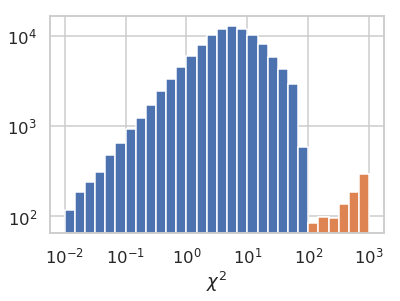

In [119]:
plt.hist(chisqr,bins=np.logspace(-2,3,31))
plt.hist(chisqr[bad],bins=np.logspace(-2,3,31))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\chi^{2}$')

Text(0,0.5,'Log $\\left(M_{\\star}^{COSMOS} / M_{\\star}^{BMA} \\right)$')

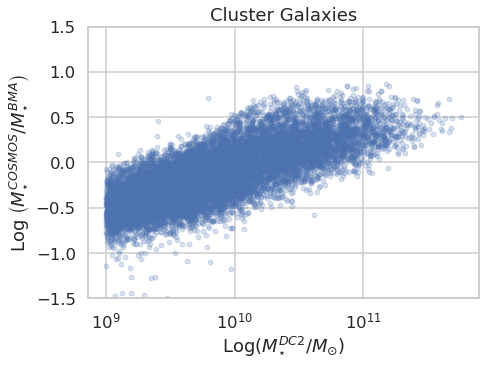

In [113]:
fig, axis = plt.subplots(1, 1, figsize=(7,5), sharex='all',sharey='all')
residual_logmas(gal[mask] ,'mass',alpha=0.2,s=20,ax=axis,title='Cluster Galaxies',density=False)
axis.set_ylim(-1.5,1.5)
axis.set_ylabel(mass_label)

Text(0,0.5,'$M_r^{BMA}-M_r^{COSMOS}$')

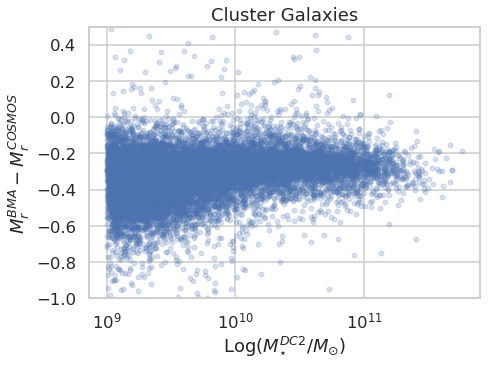

In [114]:
fig, axis = plt.subplots(1, 1, figsize=(7,5), sharex='all',sharey='all')
residual_logmas(gal[mask] ,'Mr',alpha=0.2,s=20,ax=axis,title='Cluster Galaxies',density=False)
axis.set_ylim(-1.,0.5)
axis.set_ylabel(mr_label)

In [116]:
colorList = ['#A93226','#2E86C1','#273746']

('mean:', -0.14)


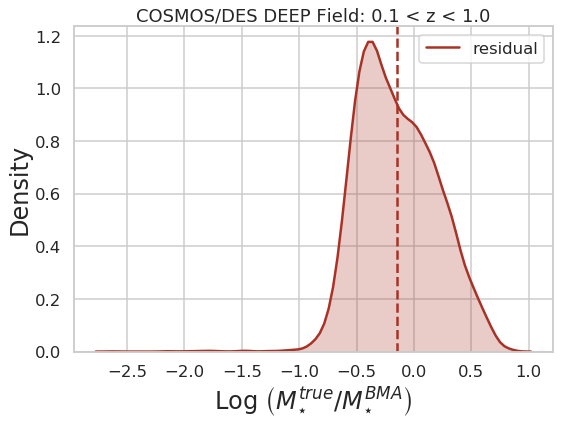

In [117]:
import warnings; warnings.simplefilter('ignore')
plt.figure(figsize=(8,6))
mass_hist_residual(mass[mask],mass_t[mask],ci=colorList[0])
# mass_hist_residual(mass[optimal],mass_t[optimal],ci=colorList[1],lb='Opt. Selection')
#mass_hist_residual(mass[bads],mass_t[bads],ci=colorList[2],lb='Est.  Members')

# plt.xlim(-1.5,1.5)
plt.xlabel(r'Log $\left(M_{\star}^{true} / M_{\star}^{BMA} \right)$',fontsize=24)
plt.ylabel('Density',fontsize=24)
plt.title('COSMOS/DES DEEP Field: 0.1 < z < 1.0')
plt.tight_layout()
plt.savefig('stellar_masss_residual_all_0.png')

In [178]:
# import warnings; warnings.simplefilter('ignore')
# plt.figure(figsize=(8,6))
# mass_hist_residual(mass[mask],mass_t[mask],ci=colorList[0],lb='True Members')
# mass_hist_residual(mass[optimal],mass_t[optimal],ci=colorList[1],lb='Opt. Selection')
# mass_hist_residual(mass[bads],mass_t[bads],ci=colorList[2],lb='Est.  Members')

# plt.xlim(-1.5,1.5)
# plt.xlabel(r'Log $\left(M_{\star}^{true} / M_{\star}^{BMA} \right)$',fontsize=24)
# plt.ylabel('Density',fontsize=24)
# plt.title('cosmoDC2: 0.1 < z < 1.0')
# plt.tight_layout()
# plt.savefig('stellar_masss_residual_all.png')

In [179]:
#### Redshift Dependence

In [180]:
def makeBins(variable,xedges):
    nsize=len(xedges)-1
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable < xedges[i + 1]))[0] for i in range(nsize)]
    return indices, xbins


In [181]:
zbins = np.array([0.1,0.2,0.4,0.6,0.8,1.0])
zlabels = ['%.2f < z < %.2f'%(zl,zh) for zl,zh in zip(zbins[:-1],zbins[1:])]

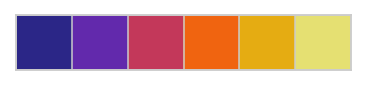

In [182]:
sns.palplot(sns.color_palette("CMRmap"))

In [183]:
colorGradient = sns.color_palette("CMRmap")[:5]

('mean:', -0.09)
('mean:', 0.04)
('mean:', 0.2)
('mean:', 0.43)
('mean:', nan)


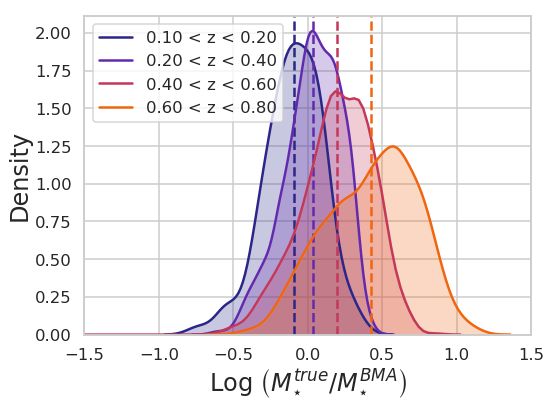

In [184]:
zcls = gal['redshift']

keys, zmean = makeBins(zcls[mask],zbins)

plt.figure(figsize=(8,6))
for i,idx in enumerate(keys):
    mass_hist_residual(mass[mask][idx],mass_t[mask][idx],ci=colorGradient[i],lb=zlabels[i])
    
plt.xlim(-1.5,1.5)
plt.xlabel(r'Log $\left(M_{\star}^{true} / M_{\star}^{BMA} \right)$',fontsize=24)
plt.ylabel('Density',fontsize=24)
plt.tight_layout()
plt.savefig('stellar_masss_residual_redshift_bins.png')

('mean:', 0.12)
('mean:', 0.23)
('mean:', 0.41)
('mean:', 0.73)
('mean:', 1.38)


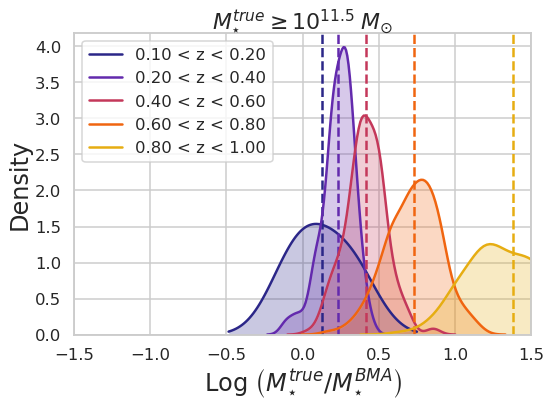

In [143]:
zcls = gal['redshift']

mask2= (mass_t>(11.))&(mask)

keys, zmean = makeBins(zcls[mask2],zbins)

plt.figure(figsize=(8,6))
for i,idx in enumerate(keys):
    mass_hist_residual(mass[mask2][idx],mass_t[mask2][idx],ci=colorGradient[i],lb=zlabels[i])
    
plt.xlim(-1.5,1.5)
plt.xlabel(r'Log $\left(M_{\star}^{true} / M_{\star}^{BMA} \right)$',fontsize=24)
plt.ylabel('Density',fontsize=24)
plt.title(r'$M_{\star}^{true}\geq 10^{11.5} \; M_{\odot}$',fontsize=22)
plt.tight_layout()
plt.savefig('stellar_masss_residual_redshift_bins.png')

('mean:', -0.09)
('mean:', 0.04)
('mean:', 0.21)
('mean:', 0.51)
('mean:', 1.13)


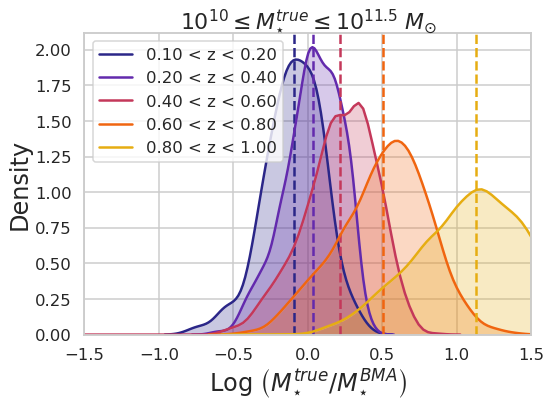

In [144]:
zcls = gal['redshift']

mask2= (mass_t>(10))&(mass_t<(11.5))&(mask)

keys, zmean = makeBins(zcls[mask2],zbins)

plt.figure(figsize=(8,6))
for i,idx in enumerate(keys):
    mass_hist_residual(mass[mask2][idx],mass_t[mask2][idx],ci=colorGradient[i],lb=zlabels[i])
    
plt.xlim(-1.5,1.5)
plt.xlabel(r'Log $\left(M_{\star}^{true} / M_{\star}^{BMA} \right)$',fontsize=24)
plt.ylabel('Density',fontsize=24)
plt.title(r'$ 10^{10} \leq M_{\star}^{true}\leq 10^{11.5} \; M_{\odot}$',fontsize=22)
plt.tight_layout()
plt.savefig('stellar_masss_residual_redshift_bins.png')

('mean:', 0.55)
('mean:', 0.79)
('mean:', 0.93)
('mean:', 0.99)


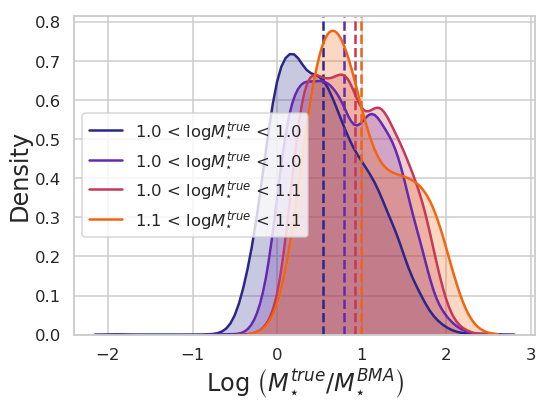

In [145]:
massbins = np.log10(np.logspace(10,12.,5))
mlabels = ['%.1f < $\log{M_{\star}^{true}}$ < %.1f'%(np.log10(ml),np.log10(mh)) for ml,mh in zip(massbins[:-1],massbins[1:])]

mask2 = mask#&(zcls>0.4)&(zcls<0.6)
keys, zmean = makeBins(mass_t[mask2],massbins)

plt.figure(figsize=(8,6))
for i,idx in enumerate(keys):
    mass_hist_residual(mass[mask2][idx],mass_t[mask2][idx],ci=colorGradient[i],lb=mlabels[i])
    
# plt.xlim(-1.5,1.5)
plt.xlabel(r'Log $\left(M_{\star}^{true} / M_{\star}^{BMA} \right)$',fontsize=24)
plt.ylabel('Density',fontsize=24)
plt.tight_layout()
plt.savefig('stellar_masss_residual_redshift_bins.png')

(array([8.0000e+00, 1.2000e+02, 1.0220e+03, 3.7930e+03, 1.8782e+04,
        4.2704e+04, 3.2625e+04, 1.2712e+04, 1.2690e+03, 8.0000e+00]),
 array([0.74892019, 0.78327185, 0.8176235 , 0.85197516, 0.88632682,
        0.92067848, 0.95503013, 0.98938179, 1.02373345, 1.05808511,
        1.09243676]),
 <a list of 10 Patch objects>)

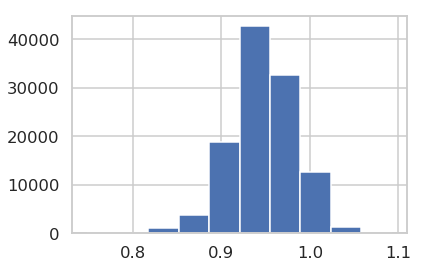

In [119]:
plt.hist(np.log10(mass))

In [120]:
def mass_scatter_residual(x1,x2,x3,zlabel='$z_{cls}$'):
    cut = remove_nan(x2)
    x = x2[cut]-x1[cut]
    
    idx = np.argsort(-1*x3)
    plt.scatter(np.log10(x1)[idx],x[idx],c=x3[idx],cmap='RdBu',s=5,alpha=0.8)
    cbar = plt.colorbar()
    cbar.set_label(zlabel)

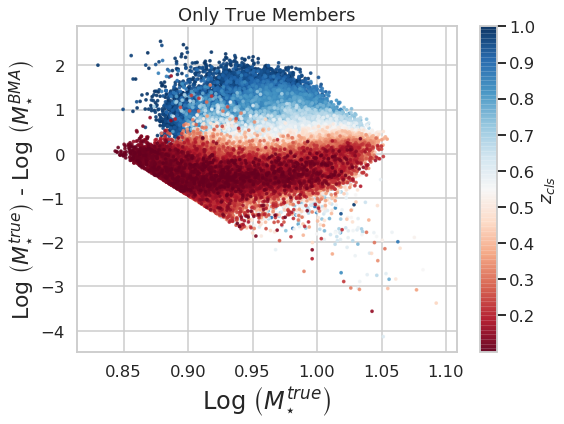

In [121]:
plt.figure(figsize=(8,6))
mass_scatter_residual(mass[mask],mass_t[mask],zcls[mask])
plt.ylabel(r'Log $\left(M_{\star}^{true} \right)$ - Log $\left( M_{\star}^{BMA} \right)$',fontsize=22)
plt.xlabel(r'Log $\left(M_{\star}^{true} \right)$',fontsize=24)

# plt.xlim(9.5,12.5)
# plt.ylim(-1.5,1.5)
plt.title('Only True Members')
plt.tight_layout()
plt.savefig('stellar_mass_residual_mtrue.png')

In [20]:
magi = gal['mag'][:,3]
amag = gal['rabs']
pmem = gal['Pmem']

In [40]:
def get_percentile_curve(x,y,q=95,nbins=12):
    xedges = np.linspace(0.98*np.min(x),1.02*np.max(x),nbins)
    keys, xmean = makeBins(x,xedges)
    ypercentile = [np.percentile(y[idx],q) for idx in keys]
    return xmean, ypercentile
    
def plot_redshift_variable(x,y,q=95,ax=None,weights=None):
    if ax is None: ax = plt.axes()
    cut = remove_nan(y)
    x, y = x[cut], y[cut]
    
    if weights is not None: weights = weights[cut]
        
    xb, yp = get_percentile_curve(x,y,q=q,nbins=31)
    
    ax.hexbin(x,y,gridsize=(25,25),cmap='Reds',C=weights,reduce_C_function=np.sum)
    ax.plot(xb,yp,'k--',label='%ith percentile'%(q))
    ax.set_xlabel(r'$z_{cls}$',fontsize=24)
    ax.legend()

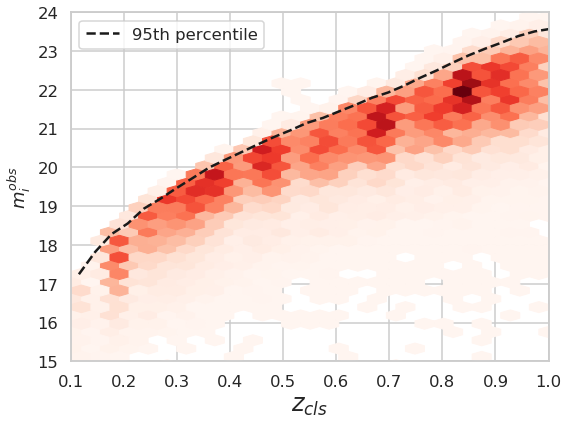

In [22]:
plt.figure(figsize=(8,6))
plot_redshift_variable(zcls,magi,weights=pmem)
plt.xlim(0.1,1.0)
plt.ylim(15,24)
plt.ylabel('$m_{i}^{obs}$')
plt.tight_layout()
plt.savefig('mag_obs_cut.png')

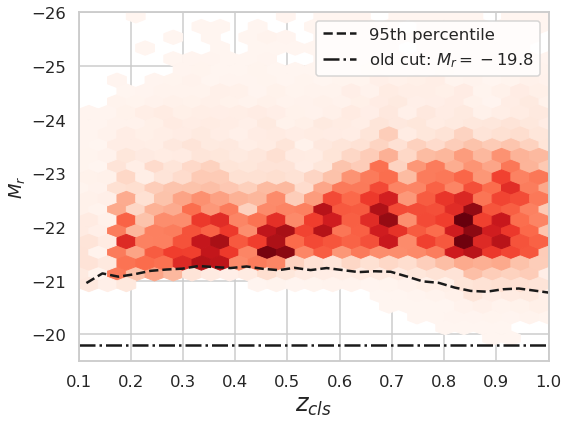

In [23]:
plt.figure(figsize=(8,6))
plot_redshift_variable(zcls,amag,weights=pmem)
plt.axhline(-19.8,color='k',linestyle='-.',label='old cut: $M_{r}=-19.8$')
plt.xlim(0.1,1.0)
plt.ylim(-19.5,-26)
plt.legend()
plt.ylabel('$M_{r}$')
plt.tight_layout()
plt.savefig('amag_cut.png')

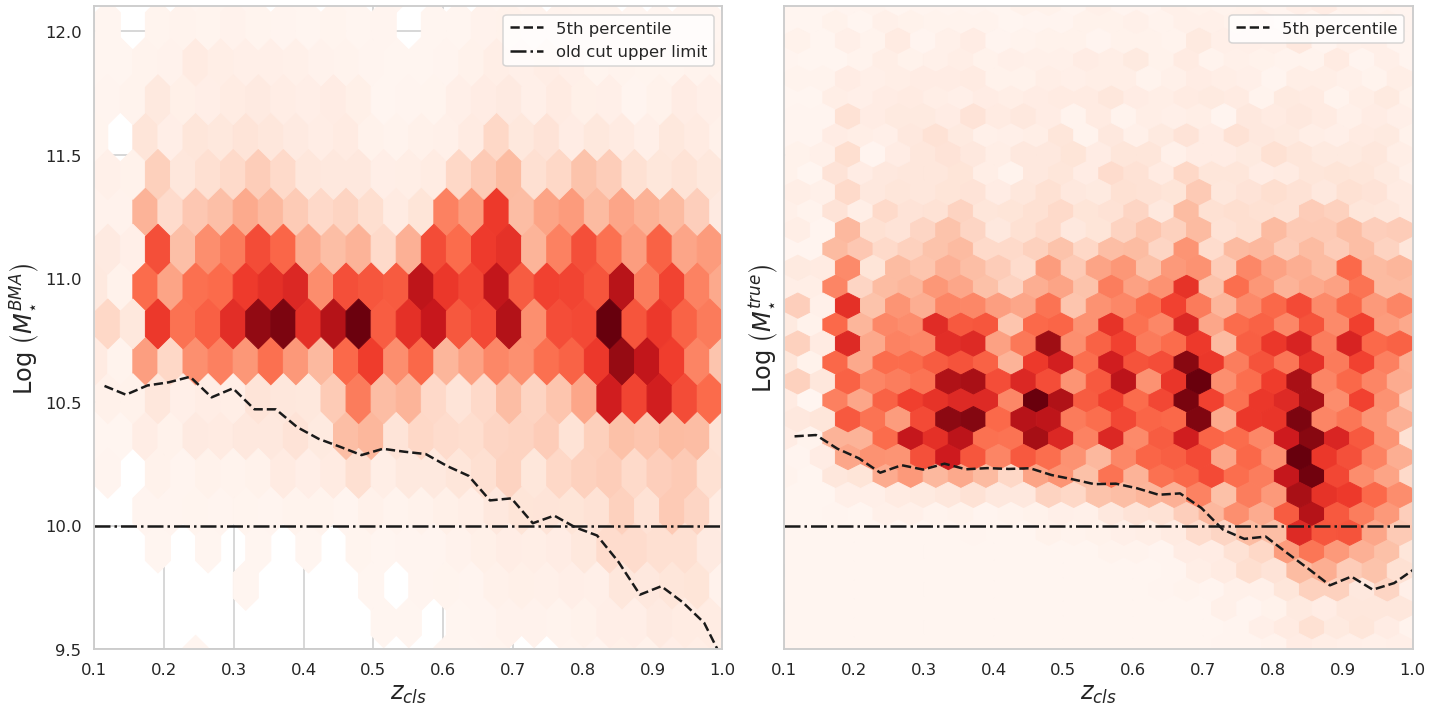

In [24]:
fig, ax = plt.subplots(1,2, sharey='row', sharex='row', figsize=(20,10))
fig.subplots_adjust(wspace=0.15)

plot_redshift_variable(zcls[bads],np.log10(mass[bads]),weights=pmem[bads],q=5,ax=ax[0])
plot_redshift_variable(zcls[mask],np.log10(mass_t[mask]),q=5, ax=ax[1])

ax[0].set_ylabel(r'Log $\left( M_{\star}^{BMA} \right)$',fontsize=24)
ax[1].set_ylabel(r'Log $\left( M_{\star}^{true} \right)$',fontsize=24)

ax[0].set_ylim(9.5,12.1)
ax[0].set_xlim(0.1,1.)

for i in range(2):
    ax[i].axhline(10,color='k',linestyle='-.',label='old cut upper limit')

ax[0].legend()
plt.tight_layout()

plt.savefig('stellar_mass_cut.png')

###  $\mu_{\star}$ precision

In this section we measure the stellar mass accuracy of BMA Stellar Mass.

In [25]:
def compute_mustar(pmem,mass,keys):
    mustar = np.array([np.nansum(pmem[idx]*mass[idx]) for idx in keys])
    return np.log10(mustar)

def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [26]:
mask = gal['True']
optimal = gal['Pmem']>0.57
bads = gal['Pmem']>0.05

keys = list(chunks(gal['CID'],cat['CID']))
keysb = list(chunks(gal['CID'][bads],cat['CID']))
keyso = list(chunks(gal['CID'][optimal],cat['CID']))
keyst = list(chunks(gal['CID'][mask],cat['CID']))

In [27]:
pmem = gal['Pmem']

mustar = compute_mustar(pmem[bads],mass[bads],keysb)
mustaro= compute_mustar(pmem[optimal],mass[optimal],keyso)

smass  = compute_mustar(np.ones_like(mass_t[mask]),mass_t[mask],keyst)

In [28]:
zcls = cat['redshift']
m200 = cat['M200_true']
ntru = cat['Ngals_true']
nobs = cat['Ngals']

logm = np.log10(m200)

In [29]:
mustar

array([12.85703956, 12.38696048, 12.38503351, ..., 12.13300354,
       12.56770208, 12.70333435])

In [30]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'

In [32]:
def plot_scaling_relation(ngals,nt,title='Buzzard'):
    #nt_bins = splitBins(nt)
    mmin, mmax = np.nanmin(nt),np.nanmax(nt)
    
    nt_bins= np.logspace(np.log10(mmin),np.log10(mmax),12)
    keys, ntb = makeBins(nt,nt_bins)
    ntb_std = np.diff(nt_bins)/2
    
    ngalsb = np.array([np.mean(ngals[idx]) for idx in keys])
    ngalsb_std = np.array([np.std(ngals[idx]) for idx in keys])
    
    ## linear fit
    linreg=lin_reg(nt,ngals)
    
    idx = np.argsort(nt)
    xt,yh = nt[idx],linreg['Yhat'][idx]

    b0 = round(linreg['b0'],3)
    b1 = round(linreg['b1'],3)
    cb_u, cb_l = linreg['cb_u'], linreg['cb_l']


    fig = plt.figure(figsize=(10,8))
    
    sc = plt.scatter(nt,ngals,s=75, alpha=0.25, color=gray)#,label='$scatter = %.1f$'%(np.std(ngals-nt))
    plt.errorbar(ntb,ngalsb,xerr=ntb_std,yerr=ngalsb_std,color=blue,linewidth=2.,fmt='o')
    
#     plt.plot(xt,yh, color="r",label='y=%.2f+%.2fx'%(b0,b1))
#     plt.fill_between(xt, cb_l, cb_u, color="gray", alpha=0.25, label='_nolabel_')
#     plt.plot(xt,cb_l, color="r", label='_nolabel_')
#     plt.plot(xt,cb_u, color="r", label='_nolabel_')

#     plt.xscale('log')
#     plt.yscale('log')
    plt.ylim(0.99*mmin,1.015*mmax)
    plt.xlim(0.99*mmin,1.015*mmax)

    plt.plot(np.linspace(0.99*mmin,1.015*mmax,100),np.linspace(0.99*mmin,1.015*mmax,100),linestyle='--',color='r')
    plt.xlabel(r'Log $(\sum{M_{\star}^{true}})$',fontsize=22)
    plt.ylabel(r'Log $(\mu_{\star})$',fontsize=22)
    plt.legend(fontsize=14)
    plt.title(title,fontsize=22)
    fig.tight_layout()
    
def lin_reg(X,Y):
    barX=np.mean(X); barY=np.mean(Y)
    XminusbarX=X-barX; YminusbarY=Y-barY
    b1=sum(XminusbarX*YminusbarY)/sum(XminusbarX**2)
    b0=barY-b1*barX
    Yhat=b0+b1*X
    e_i=Y-Yhat
    sse=np.sum(e_i**2)
    ssr=np.sum((Yhat-barY )**2)
    n=len(X)
    MSE=sse/np.float(n-2)

    s_of_yh_hat=np.sqrt(MSE*(1.0/n+(X-barX)**2/sum(XminusbarX**2)))
    W=np.sqrt(2.0*st.f.ppf(0.95,2,n-2))

    cb_upper=Yhat+W*s_of_yh_hat
    cb_lower=Yhat-W*s_of_yh_hat
    idx=np.argsort(X)

    return {'Yhat':Yhat,'b0':b0,'b1':b1,'cb_u':cb_upper[idx], 'cb_l': cb_lower[idx]}

No handles with labels found to put in legend.


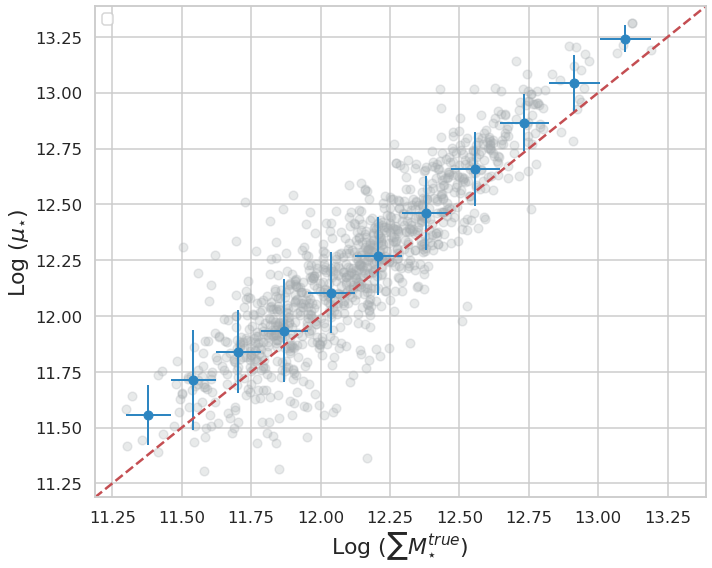

In [33]:
plot_scaling_relation(mustaro,smass,title=None)
plt.savefig('mustar_scaling_relation_optimal_r200hod.png',bb_box='tight')

In [34]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins

def splitBins(var):
    nmin = np.nanmin(var)
    n1 = np.percentile(var,10)
    n2 = np.percentile(var,20)
    n3 = np.percentile(var,30)
    n4 = np.percentile(var,40)
    n5 = np.percentile(var,50)
    n6 = np.percentile(var,60)
    n7 = np.percentile(var,70)
    n8 = np.percentile(var,80)
    n9 = np.percentile(var,90)
    nmax = np.nanmax(var)
    
    return np.array([nmin,n1,n2,n3,n4,n5,n6,n7,n8,n9,nmax])

In [35]:
def plot_residual(xvar,yvar1,yvar2, ax=None, xlabel='redshift', xbins=None):
    if ax is None: ax = plt.axes()
    
    if xbins is None:
        xbins = splitBins(xvar)
    keys, xvarb = makeBins(xvar,xbins)
    xvarb_std = np.diff(xbins)/2

    residual = (yvar1-yvar2)/yvar2

    residualb = np.array([np.nanmedian(residual[idx]) for idx in keys])
    residualb_std = np.array([np.nanstd(residual[idx]) for idx in keys])
    
    print('mean residual:',np.mean(residualb))
    print('std  residual:',np.min(residualb_std))
    
    ax.scatter(xvar,residual,color='#A6ACAF',alpha=0.25,s=75)
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=residualb_std,color='#2E86C1',fmt='o')

    ax.set_xlabel(xlabel,fontsize=18)
    # ax.set_ylabel(r'$r_{200}-r_{200,HOD}

mean residual: 0.24998260526064212
std  residual: 0.3820189310334994
mean residual: 0.028881087374166024
std  residual: 0.10419655969569197


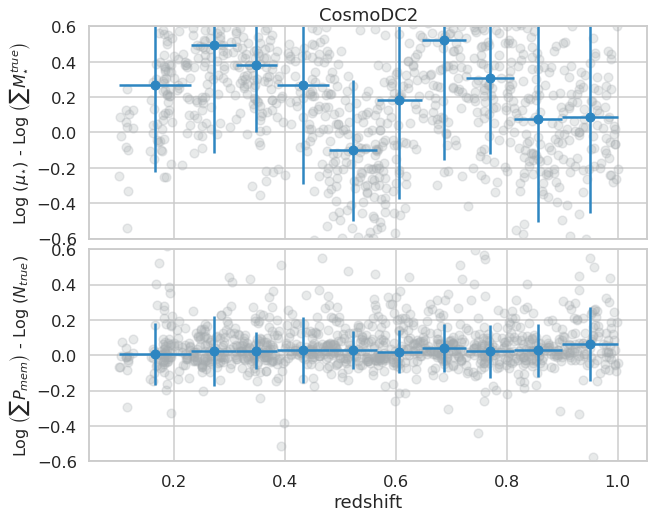

In [36]:
yvar1=10**mustaro
yvar2=10**smass

ymin,ymax = -0.6,.6

ngbins = np.logspace(np.min(np.log10(ntru)),np.max(np.log10(ntru)),9)
mbins = np.logspace(np.min(logm),np.max(logm),9)


ylabel=r'residual'

fig, ax = plt.subplots(2, 1, sharex='col', figsize=(10,8))
fig.subplots_adjust(hspace=0.05,wspace=0.6)
plot_residual(zcls,yvar1,yvar2,ax=ax[0])
plot_residual(zcls,np.log10(nobs),np.log10(ntru),ax=ax[1])

ax[0].set_ylim(ymin,ymax)
ax[0].set_ylabel(r'Log $\left(\mu_{\star} \right)$ - Log $\left( \sum{M_{\star}^{true}} \right)$',fontsize=16)
ax[0].set_xlabel(None)

ax[1].set_ylim(ymin,ymax)
ax[1].set_ylabel(r'Log $\left(\sum{P_{mem}} \right)$ - Log $\left( N_{true} \right)$',fontsize=16)

ax[0].set_title('CosmoDC2')
plt.savefig('mustar_residual_redshift.png')

mean residual: 0.24998260526064212
std  residual: 0.3820189310334994
mean residual: 0.31531827870265466
std  residual: 0.320717362360785
mean residual: 0.26231863646421155
std  residual: 0.42273164191965035


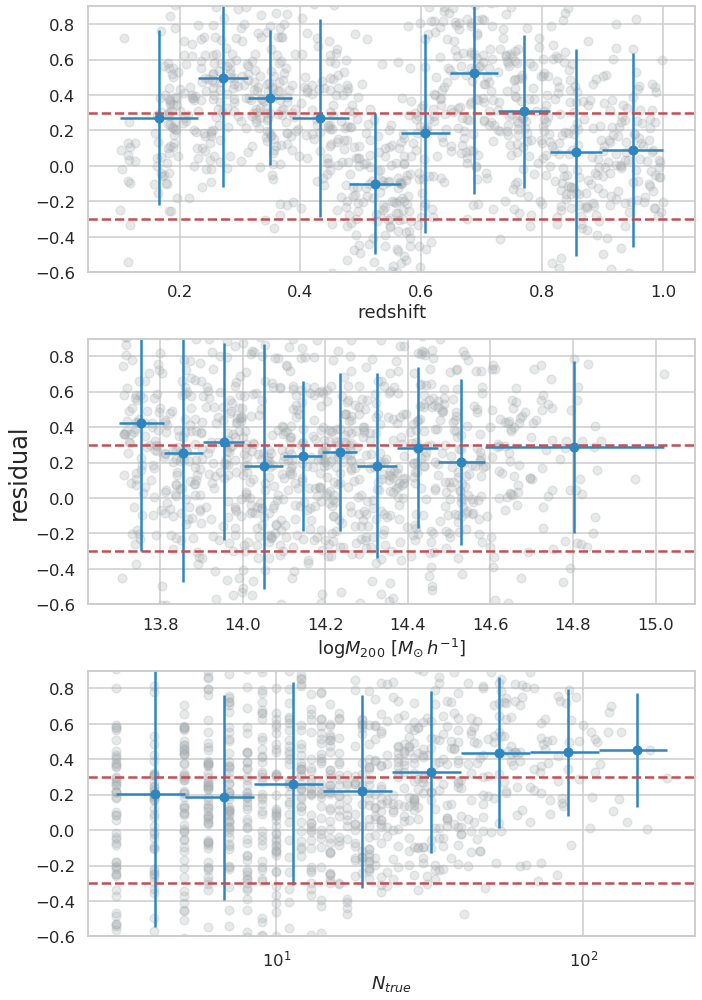

In [37]:
yvar1=10**mustaro
yvar2=10**smass

ymin,ymax = -0.6,.9

ngbins = np.logspace(np.min(np.log10(ntru)),np.max(np.log10(ntru)),9)
mbins = np.logspace(np.min(logm),np.max(logm),9)

ylabel=r'residual'
fig, ax = plt.subplots(3, 1, sharey='col', figsize=(10,14))
fig.subplots_adjust(hspace=0.4,wspace=0.6)
plot_residual(zcls,yvar1,yvar2,ax=ax[0])
plot_residual(ntru,yvar1,yvar2,ax=ax[2],xlabel=r'$N_{true}$',xbins=ngbins)
plot_residual(logm,yvar1,yvar2,ax=ax[1],xlabel=r'$\log{M_{200}}$ [$M_{\odot}\, h^{-1}$]')

# ax[0].set_title(r'$r_{200,HOD}-r_{200}$ [Mpc $h^{-1}$]',fontsize=18)
# fig.text(0.01, 0.5, ylabel, ha='center', va='center', rotation='vertical',fontsize=24)
fig.suptitle(None,fontsize=18)


ax[1].set_ylabel(ylabel,fontsize=24)
ax[2].set_xscale('log')
ax[0].set_ylim(ymin,ymax)
for i in range(3):
    ax[i].axhline(0.3,color='r',linestyle='--')
    ax[i].axhline(-0.3,color='r',linestyle='--')
fig.tight_layout()
plt.savefig('mustar_residual_cosmoDC2_bpz_r200hod.png',bb_box='tight')